Given the variety of questions, can we cluster them into ones that have to do with data availability, and those that don't?

We can try with the LDA pipeline Lisa developed for topic modeling.

In [1]:
! python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/miniconda3/lib/python3.7/site-packages/en_core_web_sm -->
/miniconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
import pandas as pd

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.attrs import ORTH, LEMMA

import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns

import inflect

import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [3]:
df = pd.read_csv("statements.csv", sep="|")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314599 entries, 0 to 1314598
Data columns (total 5 columns):
SITE_NAME           1314598 non-null object
DOCUMENTID          1314599 non-null int64
CUSTOMQUESTIONID    1314599 non-null int64
QUESTIONTEXT        1312766 non-null object
ANSWER_TEXT         1048552 non-null object
dtypes: int64(2), object(3)
memory usage: 50.1+ MB


In [5]:
df.head()

,SITE_NAME,DOCUMENTID,CUSTOMQUESTIONID,QUESTIONTEXT,ANSWER_TEXT
0,fe-besjournals,18305176,544041,If your paper is accepted for publication wher...,NaN
1,fe-besjournals,18778457,544041,If your paper is accepted for publication wher...,The databases are held in http://datadryad.org...
2,ajd,25246353,291942,Acknowledge individuals who do not qualify as ...,none
3,emi,18225548,210563,All experimental data pertinent to your manusc...,All experimental data pertinent to a review of...
4,clinical,18348956,95368,Has any of the data in this manuscript been pr...,No


In [6]:
# Drop rows with missing QUESTIONTEXT

df = df.dropna(subset=["QUESTIONTEXT"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1312766 entries, 0 to 1314598
Data columns (total 5 columns):
SITE_NAME           1312765 non-null object
DOCUMENTID          1312766 non-null int64
CUSTOMQUESTIONID    1312766 non-null int64
QUESTIONTEXT        1312766 non-null object
ANSWER_TEXT         1046719 non-null object
dtypes: int64(2), object(3)
memory usage: 60.1+ MB


In [7]:
# Remove double-spaces in QUESTIONTEXT

df["QUESTIONTEXT"] = df["QUESTIONTEXT"].str.replace("  ", " ")

In [8]:
# How many unique questions are there?

df["QUESTIONTEXT"].nunique()

1288

In [9]:
# Drop duplicate questions, assuming weights won't matter later
# Use .copy() so we're not applying to a slice of df (SettingWithCopyWarning)

questions = df.copy().drop_duplicates(subset=['QUESTIONTEXT'])

In [10]:
nlp = spacy.load('en')

In [11]:
# Add custom stop words to Spacy's list

customize_stop_words = [
    'wiley', 'br', 'href', 'url'
]
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [12]:
# Define a special case to not change "data" to "datum"

case = [{ORTH: "data", LEMMA: "data"}]

nlp.tokenizer.add_special_case("data", case)

In [13]:
def spacy_tokenizer(sentence):

    doc = nlp(sentence) 

    mytokens = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ", "PROPN"] and not token.is_stop and not token.like_url]

    prepared_text = " ".join(mytokens)

    return prepared_text

In [14]:
print(questions["QUESTIONTEXT"][0])

spacy_tokenizer(questions["QUESTIONTEXT"][0])

If your paper is accepted for publication where do you expect to archive your data or, if already archived where are the data held? Please provide details below. This location or intended location should be also given in the Data Accessibility section of your manuscript.


'paper publication data data detail location location Data Accessibility section manuscript'

In [15]:
%time questions["proc_questions"] = questions["QUESTIONTEXT"].apply(spacy_tokenizer)

CPU times: user 16.4 s, sys: 589 ms, total: 17 s
Wall time: 17.3 s


In [16]:
questions.head()

,SITE_NAME,DOCUMENTID,CUSTOMQUESTIONID,QUESTIONTEXT,ANSWER_TEXT,proc_questions
0,fe-besjournals,18305176,544041,If your paper is accepted for publication wher...,NaN,paper publication data data detail location lo...
2,ajd,25246353,291942,Acknowledge individuals who do not qualify as ...,none,Acknowledge individual author study manuscript...
3,emi,18225548,210563,All experimental data pertinent to your manusc...,All experimental data pertinent to a review of...,experimental data pertinent manuscript b acces...
4,clinical,18348956,95368,Has any of the data in this manuscript been pr...,No,data manuscript form PROTEOMICS PROTEOMICS Cli...
5,fe-besjournals,25710121,544040,"As a condition for publication, our <a href='h...",We (I) agree to archive the data associated wi...,condition publication publication journal poli...


In [17]:
tfidf_vectorizer = CountVectorizer(min_df=5, max_df=0.9)

tfidf = tfidf_vectorizer.fit_transform(questions["proc_questions"])

In [18]:
n_topics = 20

lda = LatentDirichletAllocation(n_components=n_topics)

topics_model = lda.fit(tfidf)

In [19]:
# show the top x words in each topic
n_top_words = 30
feature_names = tfidf_vectorizer.get_feature_names()


def get_top_words_topic(topic_idx):
    topic = topics_model.components_[topic_idx]

    print([feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]])


for topic_idx, topic in enumerate(topics_model.components_):
    print("Topic #%d:" % topic_idx)
    get_top_words_topic(topic_idx)
    print("")

Topic #0:
['data', 'author', 'article', 'access', 'sharing', 'analysis', 'journal', 'interpretation', 'conception', 'html', 'br', 'design', 'content', 'sample', 'statement', 'responsibility', 'acquisition', 'policy', 'resource', 'intellectual', 'open', 'citation', 'contribution', 'target', 'important', '_new', 'final', 'authors', 'version', 'list']

Topic #1:
['author', 'journal', 'html', 'homepage', 'guidelines', 'target', '10', 'information', 'issn', 'forauthors', 'manuscript', '_new', 'article', 'fee', 'paper', 'form', 'policy', 'disclosure', 'specific', 'submission', '1111', 'box', 'font', 'sure', 'individual', 'page', 'publication', 'co', 'section', 'agency']

Topic #2:
['list', 'contributor', 'description', 'comment', 'box', 'data', 'option', 'paper', 'support', 'date', 'publication', 'editor', 'public', 'financial', 'intention', 'related', 'appropriate', 'form', 'provided', 'english', 'interest', 'contribution', 'archiving', 'result', 'model', 'fee', 'theoretical', 'target', 're

In [20]:
# optionally name your topics
dict_topic_name = {i: "topic_" + str(i) for i in range(n_topics)}

custom_names = {
    0: "topic_0",
    1: "topic_1",
    
}

dict_topic_name.update(custom_names)

print(dict_topic_name)

{0: 'topic_0', 1: 'topic_1', 2: 'topic_2', 3: 'topic_3', 4: 'topic_4', 5: 'topic_5', 6: 'topic_6', 7: 'topic_7', 8: 'topic_8', 9: 'topic_9', 10: 'topic_10', 11: 'topic_11', 12: 'topic_12', 13: 'topic_13', 14: 'topic_14', 15: 'topic_15', 16: 'topic_16', 17: 'topic_17', 18: 'topic_18', 19: 'topic_19'}


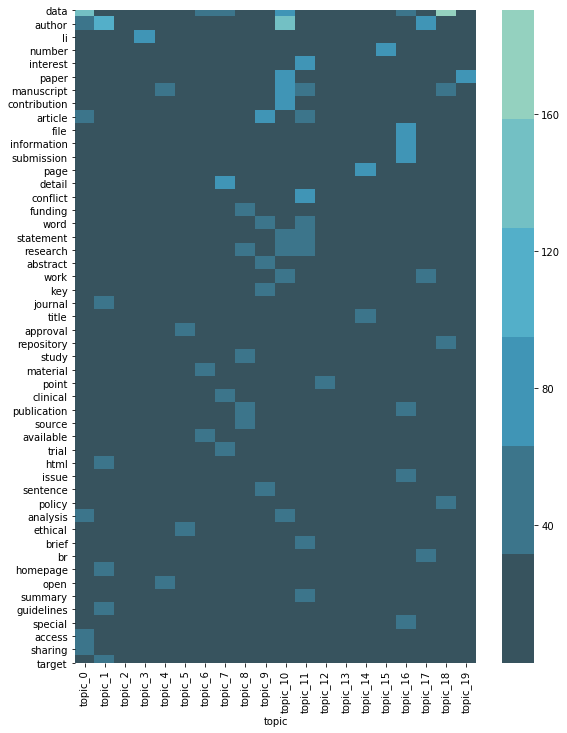

In [21]:
# show which words are most important in the topics
word_model = pd.DataFrame(topics_model.components_.T)
word_model.index = feature_names
word_model.columns.name = "topic"
word_model["norm"] = (word_model).apply(lambda x: x.abs().max(), axis=1)
word_model = word_model.sort_values(
    by="norm", ascending=0
)  # sort the matrix by the norm of row vector
word_model.rename(columns=dict_topic_name, inplace=True)  # naming topic

del word_model["norm"]

plt.figure(figsize=(9, 12))
cmap = sns.color_palette("GnBu_d")
sns.heatmap(word_model[:50], cmap=cmap)

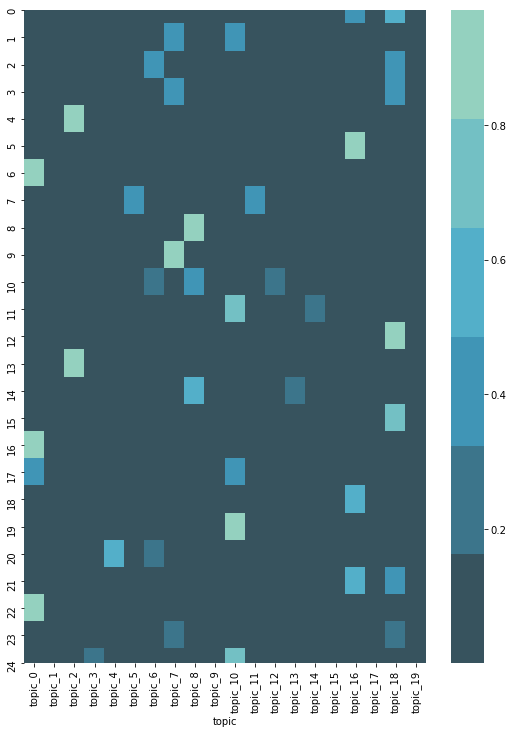

In [22]:
# retrieve the document-topic matrix - show which topic is dominant in each "document"
document_model = pd.DataFrame(topics_model.transform(tfidf))
document_model.columns.name = 'topic'
document_model.rename(columns = dict_topic_name, inplace = True) #naming topics
plt.figure(figsize=(9,12))
sns.heatmap(document_model.sort_index()[:25], cmap=cmap) #we limit here to the first 25 texts

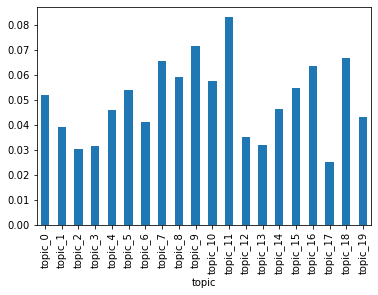

In [23]:
topics_proportion = document_model.sum()/document_model.sum().sum()
topics_proportion.plot(kind = "bar")

In [24]:
def top_documents_topics(topic_name, n_doc = 3, excerpt = True):
    '''This returns the n_doc documents most representative of topic_name'''
    
    p = inflect.engine()
    
    document_index = list(document_model[topic_name].sort_values(ascending = False).index)[:n_doc]
    
    for order, i in enumerate(document_index):
        
        print(f"Text for the {p.ordinal(order + 1)} most representative document ({i}) for topic {topic_name}:\n")
        print(questions.iloc[i,3])
        print("\n******\n")

In [25]:
top_documents_topics("topic_3", n_doc=10)

Text for the 1st most representative document (68) for topic topic_3:

<b>Is your manuscript a research study involving human subject?</b><br> (Every research study involving human subjects must be registered in a publicly Accessible database before recruitment of the first subject, following the Declaration of Helsinki update 2013. Retrospective studies and others with special conditions are excludes from this policy. Please refer to the Instruction for Authors and the newest version of the Declaration of Helsinki for further detail) <br><br><font color=red> If your answer is "No,â€ please skip the second question below [â€œIf yes, is the research in your manuscript registered?â€] and go to the next step by clicking â€œSave and Continueâ€ at the right bottom of this page. If you have accidentally checked â€œnoâ€ in the 2nd question, please fill in â€œn/aâ€ in the comment box in order to proceed to the next stage. </font>

******

Text for the 2nd most representative document (953

In [26]:
topic_vis_data = pyLDAvis.sklearn.prepare(topics_model, tfidf, tfidf_vectorizer, sort_topics=False)
pyLDAvis.display(topic_vis_data)

/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


